# **Pipeline with Deep Features**

In this notebook, we'll:
1. Load (or extract) deep features from a set of images (Oxford Flowers or any dataset).
2. Train a single KMeans and GMM model (both with 256 clusters/components).
3. Set up a VLAD encoder using the KMeans model.
4. Set up a Fisher Vector encoder using the GMM model.
5. Use each encoder separately for retrieval, then combine them in a pipeline, and compare retrieval metrics.

For more detail, see the paper below.

Reference:
=================
[1]Weixia Zhang, Jia Yan, Wenxuan Shi, Tianpeng Feng, and Dexiang Deng, "Refining Deep Convolutional Features for Improving Fine-Grained Image Recognition," EURASIP Journal on Image and Video Processing, 2017.

In [1]:
from torchvision.models import vgg16, VGG16_Weights

from scripts.train import train_k_means, train_gmm
from pyvisim._utils import *
from pyvisim._config import ROOT
from pyvisim.features import DeepConvFeature
from pyvisim.encoders import VLADEncoder, FisherVectorEncoder, Pipeline
from pyvisim.datasets import OxfordFlowerDataset  # or any dataset you have

Device used: cuda


C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## **1. Load Dataset and Extract Deep Features**
We'll load a subset of images and collect their deep descriptors.


In [2]:
train_dataset = OxfordFlowerDataset(
    purpose="train",
)

# Let's define our deep extractor

In [3]:
model = vgg16(weights=VGG16_Weights.DEFAULT)
extractor = DeepConvFeature(
    model=model,
    layer_index=-1,
    spatial_encoding=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

2025-01-09 15:04:32,618 - Feature_Extractor - INFO - Selected layer: features.28, Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# We'll gather a list of descriptors from some images:

In [4]:
labels, paths, features = [], [], []
for img, lbl, path in train_dataset:
    labels.append(lbl)
    paths.append(path)
    features.append(extractor(img))

labels = np.array(labels)
features = np.vstack(features)

## **2. Train K-Means and GMM (256 Clusters)**


In [5]:
num_clusters = 256

print("Fitting K-Means with 256 clusters...")
kmeans_model = train_k_means(n_clusters=num_clusters, features=features)
try:
    save_model(kmeans_model, f"{ROOT}/models/pickle_model_files/kmeans_k256_deep_features_vgg16_no_pca.pkl")
except Exception as e:
    print(f"Error saving KMeans model: {e}")

print("Fitting GMM with 256 components...")
gmm_model = train_gmm(n_components=num_clusters, features=features)
try:
    save_model(gmm_model, f"{ROOT}/models/pickle_model_files/gmm_k256_deep_features_vgg16_no_pca.pkl")
except Exception as e:
    print(f"Error saving GMM model: {e}")

# If you previously trained the model, you can load them (if they were successfully saved)


In [5]:
kmeans_model = load_model(f"{ROOT}/models/pickle_model_files/k_means_k256_deep_features_vgg16_no_pca.pkl")
gmm_model = load_model(f"{ROOT}/models/pickle_model_files/gmm_k256_deep_features_vgg16_no_pca.pkl")

## **3. Initialize Encoders: VLAD and Fisher Vector**


In [6]:
vlad_encoder = VLADEncoder(
    feature_extractor=extractor,
    kmeans_model=kmeans_model,
    power_norm_weight=1)

fisher_encoder = FisherVectorEncoder(
    feature_extractor=extractor,
    gmm_model=gmm_model,
    power_norm_weight=0.5,
)

## **4. Compute vectors**


### Select images for comparison

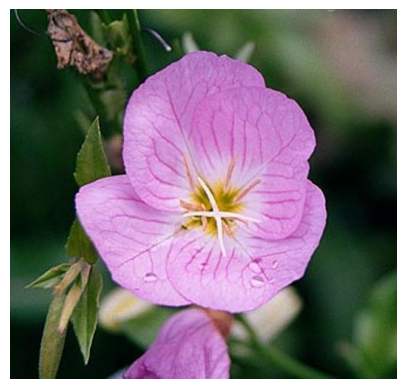

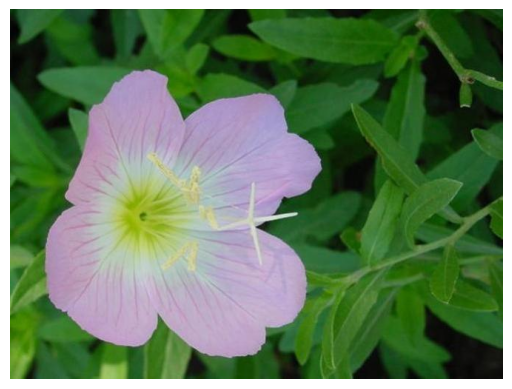

In [7]:
image1, *_ = train_dataset[0]
image2, *_ = train_dataset[1]
plot_image(image1)
plot_image(image2)

### Compute VLAD and Fisher Vectors

In [8]:
fisher_vector_1 = fisher_encoder.encode(image1)
vlad_vector_1 = vlad_encoder.encode(image1)
print(f"Shape of Fisher Vector: {fisher_vector_1.shape}, Shape of VLAD Vector: {vlad_vector_1.shape}")

fisher_vector_2 = fisher_encoder.encode(image2)
vlad_vector_2 = vlad_encoder.encode(image2)

Shape of Fisher Vector: (1, 263424), Shape of VLAD Vector: (1, 131584)


### Compute similarity scores using VLAD and Fisher Vectors

In [9]:
print("Cosine similarity using VLAD:", vlad_encoder.similarity_score(image1, image2))
print("Cosine similarity using Fisher Vectors:", fisher_encoder.similarity_score(image1, image2))

Cosine similarity using VLAD: 0.0422673225402832
Cosine similarity using Fisher Vectors: 0.11233420067187681


## Use a Pipeline

We can combine both steps above by using the pipeline class.

In [10]:
pipeline = Pipeline(
    [vlad_encoder, fisher_encoder])

### Compare images using the pipeline

The result is the similarity score of the concatenated VLAD and Fisher vectors.

In [11]:
sim_score = pipeline.similarity_score(image1, image2)
print("Scores using the pipeline:", sim_score)

Scores using the pipeline: 0.0437275253336626


This is equal to:

In [14]:
combined_vector_1 = np.hstack((vlad_vector_1, fisher_vector_1))
combined_vector_2 = np.hstack((vlad_vector_2, fisher_vector_2))
print("Cosine similarity using concatenated vectors:", cosine_similarity(combined_vector_1, combined_vector_2)) # Cosine similarity was chosen as `similarity_func` for the encoders

Cosine similarity using concatenated vectors: [[0.04372753]]


You can also compare two batches of images at once. The shape is the similarity matrix of size (batch_1_size, batch_2_size).

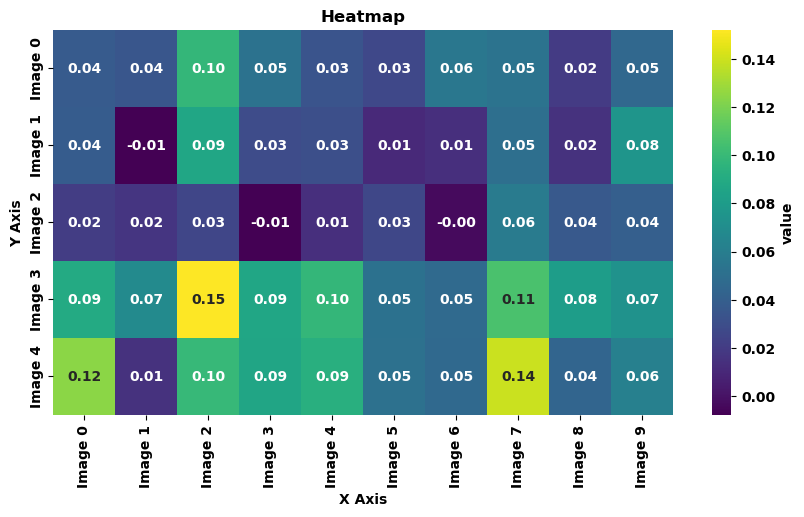

In [15]:
batch_1 = (train_dataset[i][0] for i in range(5))
batch_2 = (train_dataset[i][0] for i in range(5, 15))
similarity_matrix = pipeline.similarity_score(batch_1, batch_2)
plot_and_save_heatmap(similarity_matrix, x_tick_labels=[f"Image {i}" for i in range(10)],
                        y_tick_labels=[f"Image {i}" for i in range(5)],
                      figsize=(10, 5))

You can call the `encode` method, just like with `VLADEncoder` and `FisherVectorEncoder`. Each image is encoded using the encoders in the pipeline, and the end result is the concatenation of the vectors.

In [16]:
images_1_5 = [train_dataset[i][0] for i in range(5)]
encoding = pipeline.encode(images_1_5)
print("Shape of encoded batch:", encoding.shape) # (num_images, dim_vlad + dim_fisher)

Shape of encoded batch: (5, 395008)


### Generate encoding map

The keys will be the image paths and the values are the concatenated VLAD and Fisher vectors.

In [17]:
image_paths = [train_dataset[i][2] for i in range(5)]
encoding_map = pipeline.generate_encoding_map(image_paths)
{os.path.basename(k): v for k, v in encoding_map.items()}

{'image_06734.jpg': array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        9.00320763e-106, 6.60009532e-106, 3.31801012e-106]),
 'image_06735.jpg': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.41956826e-92,  1.20481656e-92, -6.40453969e-92]),
 'image_06737.jpg': array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.20573304e-160, 1.20959656e-160, 1.10655677e-160]),
 'image_06742.jpg': array([0., 0., 0., ..., 0., 0., 0.]),
 'image_06743.jpg': array([0., 0., 0., ..., 0., 0., 0.])}

Print the pipeline to see the encoders it contains.

In [18]:
print(pipeline)

Pipeline(
encoders=[VLADEncoder(feature_extractor=DeepConvFeature, 
similarity_func=cosine_similarity, 
Number of clusters/components=256, 
power_norm_weight=1, 
norm_order=2)
FisherVectorEncoder(feature_extractor=DeepConvFeature, 
similarity_func=cosine_similarity, 
Number of clusters/components=256, 
power_norm_weight=0.5, 
norm_order=2)],
similarity_func=cosine_similarity)
